# Reading from example SITL CSV and sourcing relevant data

The code does two things:

- Puts an SITL report into a basic DataFrame.
- Extracts an "event" (BBF) from the report, loads the MMS data and plots the relevant time frame.

In [127]:
# Just to get rid of IPython deprecation warnings:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# std lib imports
import os
import datetime as dt
# 3rd party imports
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# local pkg imports
import pyspedas # as spds
import pytplot

# MeMes package imports:
import retrieve_sitl

26-Aug-20 18:03:30: /Users/payette/HW_20/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



#### Read the data using get()

This returns all the data, sorted but otherwise unchanged.

In [128]:
pickle_path = "../pydata/reports_df.p"
if os.path.exists(pickle_path):
    print("Reading pickle data")
    reports_df = pd.read_pickle(pickle_path)
else:
    print("Downloading data from source. This will take some minutes...")
    reports_df = retrieve_sitl.get()
    # Pickle the data for quicker loading because reading it takes forever:
    reports_df.to_pickle(pickle_path)

Reading pickle data


In [129]:
reports_df.head(5)

,datetime,FOM,ID,Discussion
0,2016-04-05/13:32:14 - 2016-04-05/13:35:54,20.0,jholmes(EVA),Continuation past crossing with some B rotati...
1,2016-04-05/13:43:24 - 2016-04-05/13:45:34,14.0,jholmes(EVA),Near boundary with B-field activity
2,2016-04-05/13:45:34 - 2016-04-05/13:47:54,8.0,jholmes(EVA),"E-field spikes, possible waves"
3,2016-04-05/13:48:24 - 2016-04-05/13:50:54,17.0,jholmes(EVA),"Strong E and B activity, ion flow reversal. B..."
4,2016-04-05/17:05:04 - 2016-04-05/17:07:04,18.0,jholmes(EVA),"Boundary skim, density gradient, E-field sign..."


#### Parse the data so it's easier to work with

Split the datetime objects and combine all rows with identical discussions into one (while keeping the relevant start times and end times).

Add FOM field as new FLOAT column, add boolean fields for string searches for 'BBF' and 'DF'.

TODO: Add duration field calculated from datetime/Starttime/Endtime

In [146]:
reports_df = retrieve_sitl.parse_times(reports_df)
#reports_df = reports_df.drop(columns='datetime') # Don't re-run this cell
reports_df = retrieve_sitl.combine_rows(reports_df)
# More parsing
reports_df['FOM_float'] = reports_df['FOM'].astype(float) # Add FOM as float for query operations
reports_df['Duration'] = (reports_df['Starttime']-reports_df['Endtime']) #need fixing
reports_df['Discussion_contains_BBF'] = False #Create boolean field for BBF, initially set as False
reports_df['Discussion_contains_DF'] = False #Create boolean field for DF, initially set as False
reports_df['Discussion_contains_uncertainty'] = False

mask_BBF = reports_df.Discussion.str.contains('BBF',case=False) #Create mask, string search case insensitive for 'BBF'
mask_BBF2 = reports_df.Discussion.str.contains('bulk flow',case=False) 
mask_DF = reports_df.Discussion.str.contains('DF',case=False) #Create mask, string search case insensitive for 'DF'
mask_DF2 = reports_df.Discussion.str.contains('dipolarization',case=False)

mask_uncertainty  = reports_df.Discussion.str.contains("maybe")
mask_uncertainty2 = reports_df.Discussion.str.contains("possibl")
mask_uncertainty3 = reports_df.Discussion.str.contains("?", regex=False)

reports_df.loc[mask_BBF,'Discussion_contains_BBF'] = True #Set rows from mask equal to True
reports_df.loc[mask_BBF2,'Discussion_contains_BBF'] = True 
reports_df.loc[mask_DF,'Discussion_contains_DF'] = True #Set rows from mask equal to True
reports_df.loc[mask_DF2,'Discussion_contains_DF'] = True 

reports_df.loc[mask_uncertainty,'Discussion_contains_uncertainty'] = True
reports_df.loc[mask_uncertainty2,'Discussion_contains_uncertainty'] = True
reports_df.loc[mask_uncertainty3,'Discussion_contains_uncertainty'] = True

#reports_df['Discussion_contains_BBF'].iloc[18883] == True #Evaluate example for 'BBF' == TRUE
#reports_df['Discussion_contains_BBF'].iloc[2] == False #Evaluate example for no 'BBF' == FALSE

reports_df.head(5)

,datetime,FOM,ID,Discussion,FOM_float,Discussion_contains_BBF,Discussion_contains_DF,Discussion_contains_uncertainty,Starttime,Endtime,Day,Duration
0,2016-04-05/13:32:14 - 2016-04-05/13:35:54,20.0,jholmes(EVA),Continuation past crossing with some B rotati...,20.0,False,False,False,2016-04-05 13:32:14,2016-04-05 13:35:54,2016-04-05,-1 days +23:56:20
1,2016-04-05/13:43:24 - 2016-04-05/13:45:34,14.0,jholmes(EVA),Near boundary with B-field activity,14.0,False,False,False,2016-04-05 13:43:24,2016-04-05 13:45:34,2016-04-05,-1 days +23:57:50
2,2016-04-05/13:45:34 - 2016-04-05/13:47:54,8.0,jholmes(EVA),"E-field spikes, possible waves",8.0,False,False,True,2016-04-05 13:45:34,2016-04-05 13:47:54,2016-04-05,-1 days +23:57:40
3,2016-04-05/13:48:24 - 2016-04-05/13:50:54,17.0,jholmes(EVA),"Strong E and B activity, ion flow reversal. B...",17.0,False,False,False,2016-04-05 13:48:24,2016-04-05 13:50:54,2016-04-05,-1 days +23:57:30
4,2016-04-05/17:05:04 - 2016-04-05/17:07:04,18.0,jholmes(EVA),"Boundary skim, density gradient, E-field sign...",18.0,False,False,False,2016-04-05 17:05:04,2016-04-05 17:07:04,2016-04-05,-1 days +23:58:00


,FOM,ID,Discussion,Starttime,Endtime,Day,FOM_float,Discussion_contains_BBF,Discussion_contains_DF,Discussion_contains_uncertainty
691,15.0,svines(EVA),Bursty bulk flow?,2016-05-31 03:08:04,2016-05-31 03:15:24,2016-05-31,15.0,True,False,False
5976,55.0,ree(EVA),Train of BBFs. Bz fluc. Some E activity. Cold...,2017-07-16 02:30:43,2017-07-16 02:45:23,2017-07-16,55.0,True,False,False
6733,70.0,svines(EVA),"Tailward flow, possible BBF or current sheet ...",2017-08-22 22:40:33,2017-08-22 22:48:03,2017-08-22,70.0,True,False,False
6734,90.0,svines(EVA),"Enhanced E-field and wave activity, possible ...",2017-08-22 22:57:33,2017-08-22 23:01:43,2017-08-22,90.0,True,True,False
11393,149.0,sboardsen(EVA),"Multiple PS crossings, BBF, Plasmoid?,strong ...",2018-06-02 18:24:43,2018-06-02 18:40:43,2018-06-02,149.0,True,False,False
11411,120.0,sboardsen(EVA),"BBF?, Vx & Vz flow reversals 200 km/s",2018-06-03 20:16:03,2018-06-03 20:17:53,2018-06-03,120.0,True,False,False
12101,95.0,ajaynes(EVA),"Fast flows earthward, possible BBFs, conjunct...",2018-08-19 17:33:53,2018-08-19 17:42:43,2018-08-19,95.0,True,False,False
12518,86.0,rtorbert(EVA),"Fast +Vx flow boundary, Bx reversals, maybe ...",2018-09-10 15:04:13,2018-09-10 15:04:43,2018-09-10,86.0,True,True,False
18707,100.0,arogers(EVA),High speed ion flows with density enhancement...,2020-06-20 08:17:33,2020-06-20 08:20:03,2020-06-20,100.0,True,False,False
18806,110.0,aardakani(EVA),PSBL with possible BBFs,2020-06-27 13:01:03,2020-06-27 13:16:33,2020-06-27,110.0,True,False,False


In [112]:
reports_df.iloc[614]['Discussion']

' Substorm activity: plasma sheet thinning, dipolarizations, bursty bulk flows with both earthward and tailward Vx >200 km/s, and energetic particle injections'

In [109]:
reports_df.query('Discussion.str.contains("bulk flow")')

26-Aug-20 17:31:24: /Users/payette/HW_20/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



,FOM,ID,Discussion,Starttime,Endtime,Day,FOM_float,Discussion_contains_BBF,Discussion_contains_DF,Discussion_contains_uncertainty
530,49.0,dturner(EVA),"Plasma sheet thinning, dipolarization, bursty...",2016-05-15 06:28:24,2016-05-15 06:55:04,2016-05-15,49.0,True,True,False
532,40.0,dturner(EVA),"Dipolarization, bursty bulk flow, and energet...",2016-05-15 07:15:04,2016-05-15 08:49:54,2016-05-15,40.0,True,True,False
535,20.0,dturner(EVA),Dipolarization and bursty bulk flows,2016-05-15 11:32:24,2016-05-15 11:42:24,2016-05-15,20.0,True,True,False
537,30.0,dturner(EVA),Bursty bulk flows and energetic particle inj...,2016-05-15 13:51:34,2016-05-15 14:06:34,2016-05-15,30.0,True,False,False
538,40.0,dturner(EVA),"Dipolarization front, bursty bulk flows, and...",2016-05-15 14:22:54,2016-05-15 14:37:34,2016-05-15,40.0,True,True,False
540,30.0,dturner(EVA),Bursty bulk flow and energetic particle injec...,2016-05-15 18:59:54,2016-05-15 19:07:44,2016-05-15,30.0,True,False,False
543,40.0,dturner(EVA),"Dipolarization, bursty bulk flow, and energe...",2016-05-16 07:08:34,2016-05-16 07:37:44,2016-05-16,40.0,True,True,False
546,40.0,dturner(EVA),"Dipolarization, bursty bulk flows, and energ...",2016-05-16 10:33:14,2016-05-16 10:53:44,2016-05-16,40.0,True,True,False
567,40.0,dturner(EVA),"Dipolarization, bursty bulk flow, and energet...",2016-05-17 18:02:34,2016-05-17 18:28:34,2016-05-17,40.0,True,True,False
598,40.0,dturner(EVA),Small substorm with classic signatures: plasm...,2016-05-20 06:09:14,2016-05-20 08:05:44,2016-05-20,40.0,True,True,False


In [72]:
#Example query for finding a "high quality"? BBF
reports_df.query('Discussion_contains_BBF == True | Discussion_contains_DF == True')

,FOM,ID,Discussion,Starttime,Endtime,Day,FOM_float,Discussion_contains_BBF,Discussion_contains_DF
124,25.0,icohen(EVA),"Dipolarization features, particle boundary an...",2016-04-13 00:37:54,2016-04-13 01:04:54,2016-04-13,25.0,False,True
298,40.0,jburch(EVA),Possible dipolarization front,2016-04-24 12:13:14,2016-04-24 16:18:24,2016-04-24,40.0,False,True
312,20.0,jburch(EVA),Possible dipolarization front,2016-04-26 10:22:34,2016-04-26 10:26:34,2016-04-26,20.0,False,True
327,40.0,jburch(EVA),Possible dipolarization event,2016-04-27 15:14:34,2016-04-27 15:45:04,2016-04-27,40.0,False,True
341,40.0,jburch(EVA),"Possible dipolarization front, 400 km/s Sunwa...",2016-04-29 10:18:24,2016-04-29 10:23:14,2016-04-29,40.0,False,True
...,...,...,...,...,...,...,...,...,...
18881,120.0,tphan(EVA),BBF/PSBL,2020-07-11 18:47:33,2020-07-11 18:50:33,2020-07-11,120.0,True,False
18882,120.0,tphan(EVA),3 BBFs,2020-07-11 19:04:13,2020-07-11 19:47:23,2020-07-11,120.0,True,False
18883,110.0,tphan(EVA),BBF,2020-07-11 19:45:13,2020-07-11 20:48:23,2020-07-11,110.0,True,False
18884,110.0,tphan(EVA),2 long BBFs,2020-07-11 21:22:33,2020-07-11 21:49:13,2020-07-11,110.0,True,False


In [61]:
#Example query for finding a "high quality"? BBF
reports_df.query('FOM_float > 120 & Discussion_contains_DF == True')

,FOM,ID,Discussion,Starttime,Endtime,Day,FOM_float,Discussion_contains_BBF,Discussion_contains_DF


In [121]:
report = reports_df.query('Discussion_contains_BBF == True & (Discussion.str.contains("maybe") | Discussion.str.contains("possibl") | Discussion.str.contains("?", regex=False))') #think we want to exclude maybes

26-Aug-20 17:37:23: /Users/payette/HW_20/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [151]:
reports_df.loc[625]

datetime                                   2016-05-22/09:03:34 - 2016-05-22/09:06:04
FOM                                                                             40.0
ID                                                                     musanova(EVA)
Discussion                           BBFs, dipolarization front, energetic partic...
FOM_float                                                                         40
Discussion_contains_BBF                                                         True
Discussion_contains_DF                                                          True
Discussion_contains_uncertainty                                                False
Starttime                                                        2016-05-22 09:03:34
Endtime                                                          2016-05-22 09:06:04
Day                                                                       2016-05-22
Duration                                                         

In [63]:
reports_df.query('Discussion_contains_BBF == True & Discussion.str.contains("possibl")') #think we want to exclude maybes

,FOM,ID,Discussion,Starttime,Endtime,Day,FOM_float,Discussion_contains_BBF,Discussion_contains_DF
6733,70.0,svines(EVA),"Tailward flow, possible BBF or current sheet ...",2017-08-22 22:40:33,2017-08-22 22:48:03,2017-08-22,70.0,True,False
6734,90.0,svines(EVA),"Enhanced E-field and wave activity, possible ...",2017-08-22 22:57:33,2017-08-22 23:01:43,2017-08-22,90.0,True,True
11393,149.0,sboardsen(EVA),"Multiple PS crossings, BBF, Plasmoid?,strong ...",2018-06-02 18:24:43,2018-06-02 18:40:43,2018-06-02,149.0,True,False
12101,95.0,ajaynes(EVA),"Fast flows earthward, possible BBFs, conjunct...",2018-08-19 17:33:53,2018-08-19 17:42:43,2018-08-19,95.0,True,False
18707,100.0,arogers(EVA),High speed ion flows with density enhancement...,2020-06-20 08:17:33,2020-06-20 08:20:03,2020-06-20,100.0,True,False
18806,110.0,aardakani(EVA),PSBL with possible BBFs,2020-06-27 13:01:03,2020-06-27 13:16:33,2020-06-27,110.0,True,False


In [147]:
reports_df.query('Discussion_contains_BBF == True & Discussion.str.contains("?", regex=False)') #think we want to exclude maybes

,datetime,FOM,ID,Discussion,FOM_float,Discussion_contains_BBF,Discussion_contains_DF,Discussion_contains_uncertainty,Starttime,Endtime,Day,Duration
691,2016-05-31/03:08:04 - 2016-05-31/03:11:34,15.0,svines(EVA),Bursty bulk flow?,15.0,True,False,True,2016-05-31 03:08:04,2016-05-31 03:11:34,2016-05-31,-1 days +23:56:30
5976,2017-07-16/02:30:43 - 2017-07-16/02:34:23,55.0,ree(EVA),Train of BBFs. Bz fluc. Some E activity. Cold...,55.0,True,False,True,2017-07-16 02:30:43,2017-07-16 02:34:23,2017-07-16,-1 days +23:56:20
11393,2018-06-02/18:24:43 - 2018-06-02/18:27:03,149.0,sboardsen(EVA),"Multiple PS crossings, BBF, Plasmoid?,strong ...",149.0,True,False,True,2018-06-02 18:24:43,2018-06-02 18:27:03,2018-06-02,-1 days +23:57:40
11411,2018-06-03/20:16:03 - 2018-06-03/20:17:53,120.0,sboardsen(EVA),"BBF?, Vx & Vz flow reversals 200 km/s",120.0,True,False,True,2018-06-03 20:16:03,2018-06-03 20:17:53,2018-06-03,-1 days +23:58:10
18824,2020-06-30/20:37:53 - 2020-06-30/20:39:53,110.0,dpayne(EVA),BBF(?),110.0,True,False,True,2020-06-30 20:37:53,2020-06-30 20:39:53,2020-06-30,-1 days +23:58:00
18836,2020-07-01/03:03:53 - 2020-07-01/03:06:13,100.0,dpayne(EVA),BBF(?). Large ion jet w/ brief reversal. So...,100.0,True,False,True,2020-07-01 03:03:53,2020-07-01 03:06:13,2020-07-01,-1 days +23:57:40
18860,2020-07-04/14:20:33 - 2020-07-04/14:22:53,150.0,dpayne(EVA),"DFs (?), BBF(?)",150.0,True,True,True,2020-07-04 14:20:33,2020-07-04 14:22:53,2020-07-04,-1 days +23:57:40


#### Find an example BBF to extract and plot

In [100]:
reports_df.iloc[11393].Discussion

26-Aug-20 16:23:34: /Users/payette/HW_20/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



' Multiple PS crossings, BBF, Plasmoid?,strong flows during weak B possible diffusion region, Vx ~500 km/s, Vx flow reversal, strong E turbulence, waves up to 1/2 fce'

In [139]:
# Take an example from dataframe:
n_event = 11393    # pick index of example event (data needs to exist!)
test_event = reports_df.loc[n_event]
description = test_event['Discussion']
starttime = test_event['Starttime']
endtime = test_event['Endtime']

# Extract dates of data we'll need for event:
trange = [(starttime - dt.timedelta(days=1)).strftime('%Y-%m-%d'), 
          (endtime + dt.timedelta(days=1)).strftime('%Y-%m-%d')]
plt_tlims = (starttime - dt.timedelta(minutes=15),
             endtime + dt.timedelta(minutes=15))
print("Using range of dates:", [starttime, endtime])
print(((endtime-starttime)))

Using range of dates: [Timestamp('2018-06-02 18:24:43'), Timestamp('2018-06-02 18:40:43')]
0 days 00:16:00


## Read MMS data

Run the first block to download the data - if you've already downloaded the data, ignore it!. The following blocks will read the downloaded files using either CDFLIB or (below) pyspedas. CDFLIB is far faster!

In [103]:
# ----------------------------------------------
# RUN THIS BLOCK TO DOWNLOAD DATA TO LOCAL PATH
# ----------------------------------------------

# update local data dir if using no_update flag
pyspedas.mms.mms_config.CONFIG['local_data_dir'] = '../pydata'

# load B-field data from FGM (Fluxgate Magnetometer)
# use no_update=True to load local data
fgm_vars = pyspedas.mms.fgm(
    trange       =  trange,
    time_clip    =   False, # could truncate residuals at trange ends
    data_rate    =  'srvy', # survey frequency
    level        =    'l2', # ensure L2 products
    probe        =     '1', # could be ['1','2','3','4'] for all spacecraft
    #no_update    =    True, # load local data
)

26-Aug-20 16:23:48: Loading ../pydata/mms1/fgm/srvy/l2/2018/06/mms1_fgm_srvy_l2_20180601_v5.141.0.cdf
26-Aug-20 16:23:48: Loading ../pydata/mms1/fgm/srvy/l2/2018/06/mms1_fgm_srvy_l2_20180602_v5.143.0.cdf


Loaded variables:
mms1_fgm_b_gse_srvy_l2
mms1_fgm_b_gsm_srvy_l2
mms1_fgm_b_dmpa_srvy_l2
mms1_fgm_b_bcs_srvy_l2
mms1_fgm_flag_srvy_l2
mms1_fgm_r_gse_srvy_l2
mms1_fgm_r_gsm_srvy_l2
mms1_fgm_hirange_srvy_l2
mms1_fgm_bdeltahalf_srvy_l2
mms1_fgm_stemp_srvy_l2
mms1_fgm_etemp_srvy_l2
mms1_fgm_mode_srvy_l2
mms1_fgm_rdeltahalf_srvy_l2


#### Read using CDF library (fast)

Reads data within the time range (plt_tlims here) specified, assuming that the files exist locally under the path base_path.

In [104]:
import retrieve_mms

local_data_dir = '../pydata'
base_path = os.path.join(local_data_dir, 'mms1', 'fgm', 'srvy', 'l2')
data = retrieve_mms.get_fgm(base_path, plt_tlims[0], plt_tlims[1])
t_utc, B_x, B_y, B_z, Bt = data

26-Aug-20 16:25:06: /Users/payette/HW_20/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Reading file at ../pydata/mms1/fgm/srvy/l2/2018/06/mms1_fgm_srvy_l2_20180602_v5.143.0.cdf


## Plot the data

Reading seems to have worked and has picked out the time of interesting signals, so let's plot...

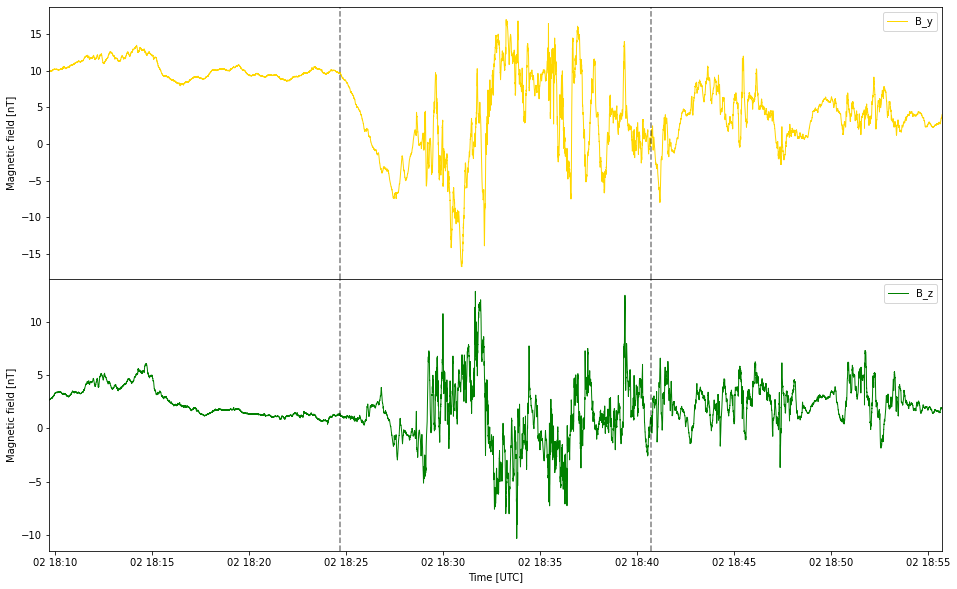

In [105]:
# convert to datetime axis
inds = np.where(np.logical_and(t_utc > plt_tlims[0], t_utc < plt_tlims[1]))

#----------------------------------------------------------------------
# plotting below
#----------------------------------------------------------------------

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,10), sharex=True)
ax1.plot_date(t_utc[inds], B_y[inds], '-', lw=1, c='gold', label='B_y')
ax2.plot_date(t_utc[inds], B_z[inds], '-', lw=1, c='green', label='B_z')
ax1.axvline(test_event['Starttime'], ls='--', c='k', alpha=0.5)
ax1.axvline(test_event['Endtime'], ls='--', c='k', alpha=0.5)
ax2.axvline(test_event['Starttime'], ls='--', c='k', alpha=0.5)
ax2.axvline(test_event['Endtime'], ls='--', c='k', alpha=0.5)
ax2.set_xlim(plt_tlims)
ax1.set_ylabel("Magnetic field [nT]")
ax2.set_ylabel("Magnetic field [nT]")
ax2.set_xlabel("Time [UTC]")
ax1.legend()
ax2.legend()
plt.subplots_adjust(hspace=0.)
plt.show()

#### Possible TODO -- after looking at this plot, we could have a manual write back to the SITL df to qualify this with a boolean as a confirmed event, that we'll want for the ML side, I think?

#### Old example: Read a single SITL report (example CSV) file

In [ ]:
# Read an example CSV file
sitl_df = pd.read_csv("../example/example_sitl_reports.csv", usecols=[0,1,2,3])

# Split the time column into start time and end time:
sitl_df[['STARTTIME','ENDTIME']] = sitl_df['START TIME - END TIME'].str.split(" - ", expand=True)
# Parse the time columns into datetime objects:
tformat_sitl = '%Y-%m-%d/%H:%M:%S'
sitl_df['STARTTIME'] = pd.to_datetime(sitl_df['STARTTIME'], format=tformat_sitl)
sitl_df['ENDTIME'] = pd.to_datetime(sitl_df['ENDTIME'], format=tformat_sitl)
# Remove the original time format:
sitl_df = sitl_df.drop(columns='START TIME          - END TIME')

sitl_df.head(15)

#### Old method: Load MMS data using pytplot (slow)

In [7]:
alldata = pytplot.get_data('mms1_fgm_b_gsm_srvy_l2')

# Extract data:
t = alldata[0]
B_x = alldata[1][:,0]
B_y = alldata[1][:,1]
B_z = alldata[1][:,2]
Bt = alldata[1][:,3]

t_utc = np.array([dt.datetime.utcfromtimestamp(i) for i in t])

26-Aug-20 13:12:20: Searching for local files...


Loading: ../pydata/mms1/fgm/srvy/l2/2016/05/mms1_fgm_srvy_l2_20160521_v4.40.0.cdf
Loading: ../pydata/mms1/fgm/srvy/l2/2016/05/mms1_fgm_srvy_l2_20160522_v4.40.0.cdf
Loading: ../pydata/mms1/fgm/srvy/l2/2016/05/mms1_fgm_srvy_l2_20160521_v4.40.0.cdf
Loading: ../pydata/mms1/fgm/srvy/l2/2016/05/mms1_fgm_srvy_l2_20160522_v4.40.0.cdf
The lengths of x and y do not match!
mms1_fgm_rdeltahalf_srvy_l2 is currently not in pytplot.
Loaded variables:
mms1_fgm_b_gse_srvy_l2
mms1_fgm_b_gsm_srvy_l2
mms1_fgm_b_dmpa_srvy_l2
mms1_fgm_b_bcs_srvy_l2
mms1_fgm_flag_srvy_l2
mms1_fgm_r_gse_srvy_l2
mms1_fgm_r_gsm_srvy_l2
mms1_fgm_hirange_srvy_l2
mms1_fgm_bdeltahalf_srvy_l2
mms1_fgm_stemp_srvy_l2
mms1_fgm_etemp_srvy_l2
mms1_fgm_mode_srvy_l2
mms1_fgm_rdeltahalf_srvy_l2
